## Run SimSS simulations and plot the results
Version 0.1
(c) Vincent M. Le Corre (https://github.com/VMLC-PV)

In [1]:
# Package import
%matplotlib inline
%matplotlib widget
# %matplotlib notebook
# comment the above line if you don't want interactive plots
import os,platform,warnings,time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# Import homemade package by VLC
from SIMsalabim_utils.GetInputPar import * # Get input parameters
from SIMsalabim_utils.RunSim import * # Run simulation
from SIMsalabim_utils.ZimT_plots import * # Plotting functions
from SIMsalabim_utils.CleanFolder import clean_up_output, clean_file_type # Cleaning functions
from SIMsalabim_utils import plot_settings_screen # Plot settings
from SIMsalabim_utils.aux_func import * # Auxiliary functions
## General Inputs
warnings.filterwarnings("ignore")           # Don't show warnings
system = platform.system()                  # Operating system
max_jobs = os.cpu_count()-2                 # Max number of parallel simulations (for number of CPU use: os.cpu_count() )
do_multiprocessing = True                      # Use multiprocessing
if system == 'Windows':                     # cannot easily do multiprocessing in Windows
        max_jobs = 1
        do_multiprocessing = False
        try:                                # kill all running jobs to avoid conflicts
            os.system('taskkill.exe /F /IM simss.exe')
        except:
            pass

# Path to SIMsalabim
path2simu = os.path.join(os.getcwd() ,'SIMsalabim','zimt')
path2devfile = os.path.join(os.getcwd() ,'Example_Data','Perovskite_examples','SPV','device_parameters.txt')

# Constants
from scipy import integrate,constants

k = constants.value('Boltzmann constant')
q = constants.value('elementary charge')
c = constants.value('speed of light in vacuum')
h = constants.value('Planck constant')
eps_0 = constants.value('vacuum electric permittivity')

In [2]:
from SIMsalabim_utils.tVG_gen import *
def zimt_trPL_Gauss_pulse(tmin,tmax,Gen_pulse,G0,tpulse,FWHM = 2e-9,tstepmin=1e-10,Gres=1e0,time_exp =False,steps=100,tVG_name='tVG.txt'):
    """Make tVG file for transient photocurrent (TPC) experiment with a gaussian pulse for the light excitation.

    Parameters
    ----------
    tmin : float
        first time step after 0 (unit: s)
    tmax : float
        final time step (unit: s)
    Gen_pulse : float
        Total number of carrier generated by the gaussian pulse (unit: m^-3)
    G0 : float
        background generation rate (i.e. light intensity) (unit: m^-3 s^-1)
    tpulse : float
        middle of the gaussian pulse (unit: s)
    FWHM : float, optional
        full width at half maximum of the gaussian pulse (unit: s), by default 2e-9
    time_exp : bool, optional
        if True chose exponential time step else keep time step linear, by default False
    steps : int, optional
        if time_exp = True number of exponential time step after voltage switch, by default 100
    tVG_name : str, optional
        tVG_file name, by default 'tVG.txt'
    """    

    # Define laser pulse by a Gaussian and always keep tstep to tstepmin for during the pulse to ensure that the amount of photon is consistent when changing tstep
    pulse_stop = tpulse + FWHM*2
    t = np.arange(tmin,pulse_stop,tstepmin)
    t=np.insert(t,0,0)
    V,G = [],[]

    for i in t:
        V.append(0)   
    G = gaussian_pulse(t,tpulse,FWHM,Gen_pulse)
    G[0] = 0 #set G = G0 at t = 0

    for i in range(len(G)):
        if G[i] < Gres:
            G[i] = 0
    
    if Gen_pulse > 0:
        # ensure that the total number of generated charges is equal to Gen
        int_G  = integrate.cumtrapz(G, t, initial=0)
        G = G*Gen_pulse/int_G[-1]
    
    if G0 > 0:
        for i in range(len(G)):
            G[i] = G[i] + G0
            

    if time_exp == True:
        t1 = np.geomspace(tstepmin,tmax-tstepmin,steps)
        t1 = t1 + pulse_stop
    else :
        t1 = np.linspace(pulse_stop, tmax, steps)

    for i in t1:
        G=np.append(G,G0)
        V.append(0)
    
    t = np.append(t,t1)

    for i in range(len(G)): #set G = 0 when G is too small (for stability in ZimT)
        if G[i] < G0:
            G[i] = G0
    
    
    

    tVG = pds.DataFrame(np.stack([t,np.asarray(V),np.asarray(G)]).T,columns=['t','Vext','Gehp'])

    tVG.to_csv(tVG_name,sep=' ',index=False,float_format='%.3e')

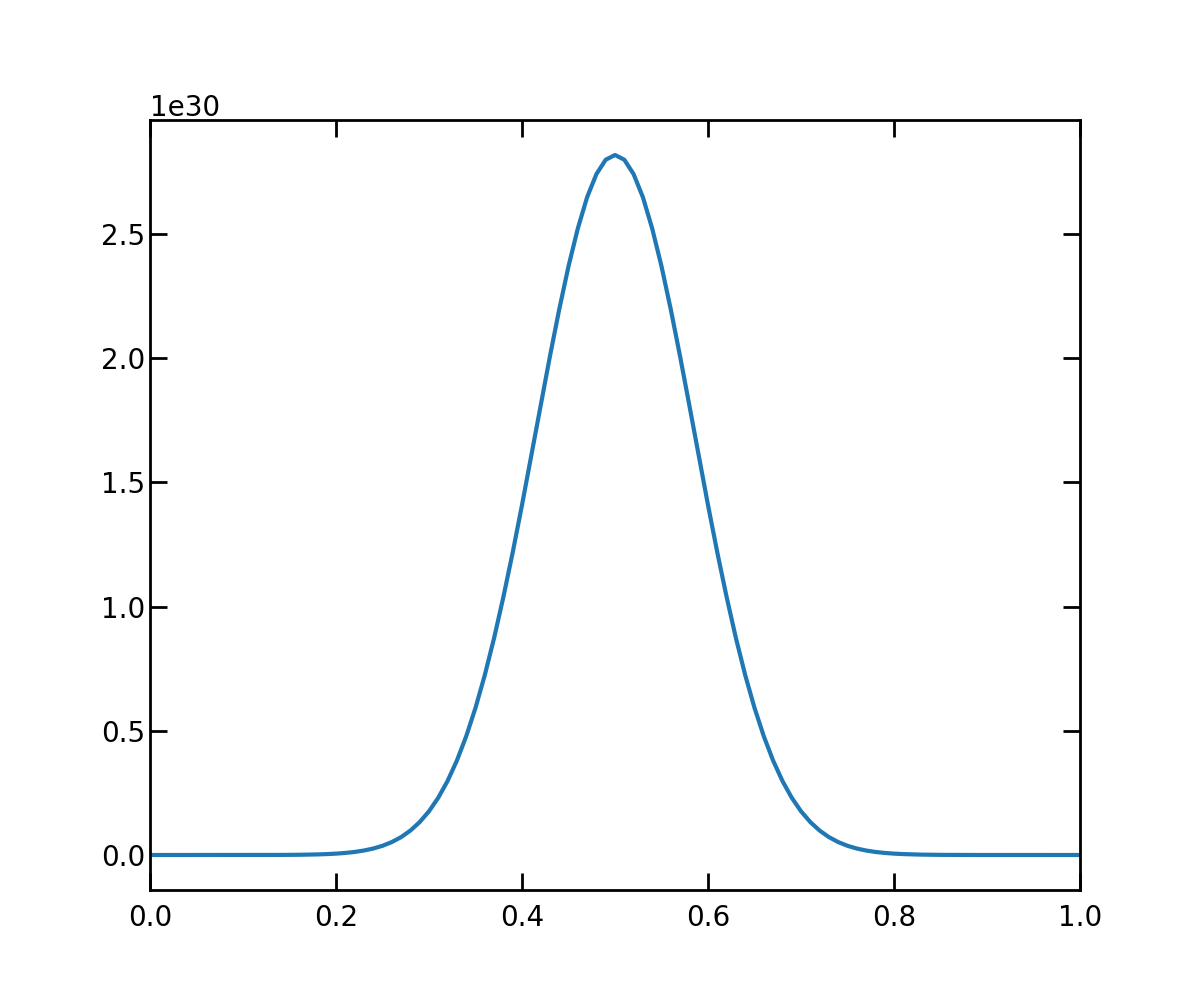

In [3]:
# test 
# zimt_trPL_Gauss_pulse(1e-10, 1e-6, 1e20, 3e27, 10e-9)
zimt_trPL_Gauss_pulse(1e-11, 1e-2, 6e20, 0, 5e-10,FWHM=2e-10,tstepmin=1e-11,steps=500,time_exp = True)
df = pd.read_csv('tVG.txt', delim_whitespace=True)

# plt.semilogy(df['t'],df['Gehp'])
plt.plot(df['t']/1e-9,df['Gehp'])
plt.xlim(0,1)
plt.show()


In [4]:
ParFileDic = ReadParameterFile(path2devfile)
L = float(ParFileDic['L'])
L_LTL = float(ParFileDic['L_LTL'])
L_RTL = float(ParFileDic['L_RTL'])
eps_r = float(ParFileDic['eps_r'])
Lac = L - L_LTL - L_RTL

wvl = 600e-9
P = 0.43 * 1e-6 / 1e-4 # J/m^2

Nb_photon = P * wvl / (h * c)
print(f'Nb_photon = {Nb_photon:.2e}')
print(f'Generation rate = {Nb_photon / Lac :.2e} m^-3')


Nb_photon = 1.30e+16
Generation rate = 3.25e+22 m^-3


In [5]:
# Gens = [1e-2 * Nb_photon / Lac] # Generation rate (m^-3 s^-1)
Gens = [6e20]#3e21,6e21]
G0s = [0e27] # Background generation rate (m^-3 s^-1)
## Prepare strings to run
# Fixed string
# fixed_str = str(path2devfile) +' -L_RTL 20e-9 -Nc_RTL 5e26 -kdirect 5e-16 -Bulk_tr 4e18 -St_R 5e10 -Cn 9e-13 -Cp 9e-15 -NP 100 -nu_int_RTL 1e3 -nu_int_LTL 1e-20 -mob_LTL 1e-10 -tolDens 1e-10 -minAcc 0.1 -maxAcc 0.1 -VB_RTL 5.5 -W_L 5.5 -W_R 5.5 -Tr_type_L -1 -Tr_type_R 1 -Tr_type_B 1' # add any fixed string to the simulation command

# fixed_str = str(path2devfile) +' -L_RTL 2e-9 -Nc_RTL 5e26 -kdirect 5e-16 -Bulk_tr 4e18 -St_R 5e13 -Cn 9e-13 -Cp 9e-20 -NP 100 -nu_int_RTL 1e-1 -nu_int_LTL 1e-20 -mob_LTL 1e-10 -tolDens 1e-10 -minAcc 0.1 -maxAcc 0.1 -VB_RTL 5.5 -W_L 5.5 -W_R 5.5 -Tr_type_L -1 -Tr_type_R -1 -Tr_type_B -1' # add any fixed string to the simulation command

fixed_str = str(path2devfile) +' -kdirect 5e-18 -Bulk_tr 4e18 -St_R 1e10 -Cn 9e-14 -Cp 9e-18 -tolDens 1e-10 -minAcc 0.1 -maxAcc 0.1 -NP 100 -nu_int_RTL 1e1 -nu_int_LTL 1e-20 -Tr_type_B -1 -OutputRatio 1' # add any fixed string to the simulation command

ParStrDic = GetParFromStr(fixed_str)
L = float(ChosePar('L',ParStrDic,ParFileDic))
L_LTL = float(ChosePar('L_LTL',ParStrDic,ParFileDic))
L_RTL = float(ChosePar('L_RTL',ParStrDic,ParFileDic))
eps_r = float(ParFileDic['eps_r'])
Lac = L - L_LTL - L_RTL


# Initialize 
code_name_lst,str_lst,path_lst,tj_lst,tVG_lst,Var_lst,labels = [],[],[],[],[],[],[]
idx = 0
start = time.time()

# Figures control
size_fig = (16, 12)
colors = cm.viridis((np.linspace(0,1,max(len(Gens),4)+1)) ) # Color range for plotting

run_simu = True
verbose = True
if run_simu:           
    # Generate tVG files and str_lst for light pulse simulation
    for Gen in Gens:
        for G0 in G0s:
            filename = 'G_{:.1e}_G0_{:.2e}.txt'.format(Gen,G0)
            zimt_trPL_Gauss_pulse(1e-11, 1e-2, Gen, G0, 1e-11,FWHM=1e-12,tstepmin=1e-11,steps=500,time_exp = True, tVG_name=os.path.join(path2simu,'tVG_'+filename+'.txt'.format(Gen,G0)))
            str_lst.append(fixed_str+' -tVG_file tVG_'+filename+'.txt -tj_file tj_'+filename+'.dat -Var_file Var_'+filename+'.dat '.format(Gen,G0,Gen,G0,Gen,G0))
            code_name_lst.append('zimt')
            path_lst.append(path2simu)
            tVG_lst.append('tVG_'+filename+'.txt'.format(Gen,G0))
            tj_lst.append('tj_'+filename+'.dat'.format(Gen,G0))
            Var_lst.append('Var_'+filename+'.dat'.format(Gen,G0))
            # labels.append(f'{val:.2e}')#+' Gen = {:.1e} m^-3 s^-1, G0 = {:.1e} m^-3 s^-1'.format(Gen,G0))
        

    # Run ZimT
    # print(len(code_name_lst),len(path_lst),len(str_lst))
    # if do_multiprocessing:
    #     print('Running parallel simulations')
    #     run_parallel_simu(code_name_lst,path_lst,str_lst,min(max_jobs,len(str_lst)))
    #     # run_multiprocess_simu(run_code,code_name_lst,path_lst,str_lst,max_jobs)
    # else:
    for i in range(len(str_lst)):
        run_code(code_name_lst[i],path_lst[i],str_lst[i],show_term_output=True,verbose=verbose)
        
print('Calculation time {:.2f} s'.format(time.time() - start)) # Time in seconds


Compiling zimt in /mnt/c/Users/lecor/Desktop/GitHub/SIMsalabim_Python/SIMsalabim/zimt
Welcome to ZimT version 4.56.
Copyright (C) 2020, 2021, 2022, 2023 S. Heester, Dr T.S. Sherkar,
Dr V.M. Le Corre, Dr M. Koopmans, F. Wobben,
and Prof L.J.A. Koster, University of Groningen.

Read parameters from /mnt/c/Users/lecor/Desktop/GitHub/SIMsalabim_Python/Example
_Data/Perovskite_examples/SPV/device_parameters.txt
Reading t, Vext, Gehp from file tVG_G_6.0e+20_G0_0.00e+00.txt.txt
The calculation has started, please wait.
Time: 0.000E+0000 Vext: 0.0000 Gehp: 0.00E+0000 Jext:   0.00 +- 0.00
Time: 1.000E-0011 Vext: 0.0000 Gehp: 1.20E+0032 Jext:-3924.62 +- 2704.79
Time: 2.200E-0011 Vext: 0.0000 Gehp: 0.00E+0000 Jext:-3988.83 +- 1471.26
Time: 2.242E-0011 Vext: 0.0000 Gehp: 0.00E+0000 Jext:-3991.35 +- 1434.06
Time: 2.287E-0011 Vext: 0.0000 Gehp: 0.00E+0000 Jext:-3993.68 +- 1398.70
Time: 2.333E-0011 Vext: 0.0000 Gehp: 0.00E+0000 Jext:-3995.57 +- 1366.03
Time: 2.381E-0011 Vext: 0.0000 Gehp: 0.00E+0000 

In [6]:
print(f'Lac = {Lac:.2e} m')
print(f'L_LTL = {L_LTL:.2e} m')
print(f'L_RTL = {L_RTL:.2e} m')

Lac = 4.00e-07 m
L_LTL = 5.00e-08 m
L_RTL = 2.00e-09 m


In [7]:
# plt.figure()
# for G0 in G0s:
#     idx = 0
#     for Gen in Gens:
#         data_tj = pd.read_csv(os.path.join(path2simu,'tj_TrPL_G_{:.1e}_G0_{:.2e}.dat'.format(Gen,G0)),delim_whitespace=True)
#         plt.loglog(data_tj['t'],data_tj['Jdir']/max(data_tj['Jdir']),label=sci_notation(Gen/1e6,sig_fig=1),color=colors[idx])
#         # zimt_tj_plot(idx,data_tj,y=['Jdir'],labels=sci_notation(Gen/1e6,sig_fig=1),colors=colors[idx],plot_type=3,save_yes=False,legend=False,pic_save_name = os.path.join(path2simu,'transient.jpg'))
#         idx += 1

# plt.show()

4.52e-07
4.4695147977e-07
5.828147836273133e+20
3.540296900416867e+21
3.9950530576251085e+18
0.0


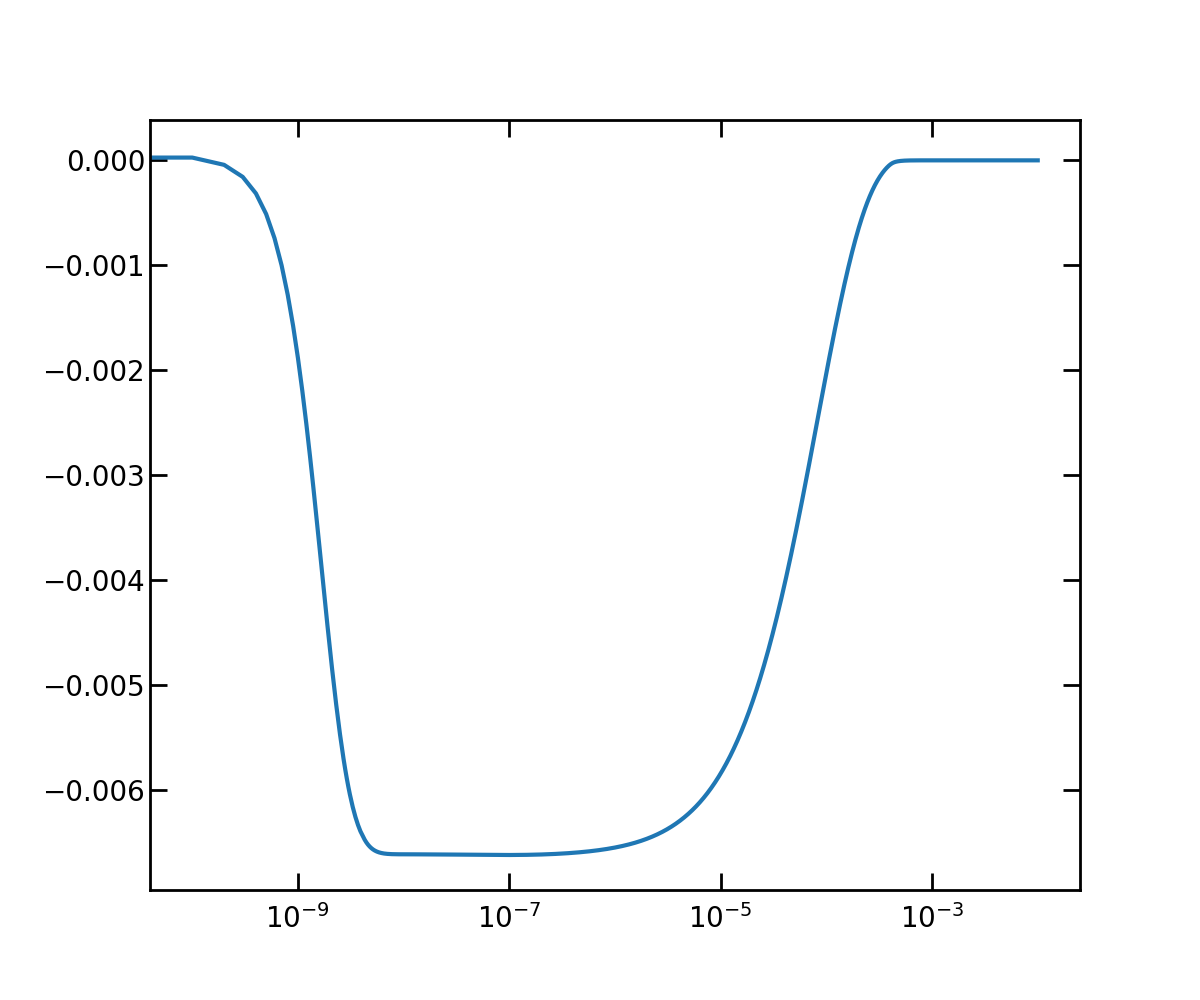

In [8]:
# ParStrDic = GetParFromStr(fixed_str)

print(float(ChosePar('L',ParStrDic,ParFileDic)))
plt.figure()
for G0 in G0s:
    idx = 0
    for Gen in Gens:
        # try:
        var_dat = pd.read_csv(os.path.join(path2simu,'Var_TrPL_G_{:.1e}_G0_{:.2e}.dat'.format(Gen,G0)),delim_whitespace=True, on_bad_lines = 'warn')

        # filter x < 5e-9
        # L = max(var_dat['x'])
        var_dat = var_dat[var_dat['mun'] == 5e-4] # make sure we are in the perovskite layer
        # var_dat = var_dat[var_dat['x'] > L_LTL]
        grouped = var_dat.groupby('time')
        Bulk_tr = float(ChosePar('Bulk_tr',ParStrDic,ParFileDic))
        St_R = float(ChosePar('St_R',ParStrDic,ParFileDic))


        St = grouped['fti1'].sum() * St_R / Lac
        
        
        # var_dat = var_dat[var_dat['x'] < L-L_RTL]
        print(max(var_dat['x']))
        grouped = var_dat.groupby('time')
        ns = grouped['n'].mean() 
        ps = grouped['p'].mean()

        # var_dat = var_dat[var_dat['x'] <= L-L_RTL]
        grouped = var_dat.groupby('time')
        nt = grouped['ftb1'].mean() * Bulk_tr
        print(max(ns))
        print(max(ps))
        print(max(nt))
        print(max(St))
        times = ns.index.values

        SPV = ((q*Lac**2/2)*(ps-ns-nt-St)/(eps_0*eps_r))
        SPV = np.asarray(SPV)
        SPV = SPV - SPV[0]


        plt.semilogx(times-2e-10,SPV )
        # except:
        #     pass

plt.show()

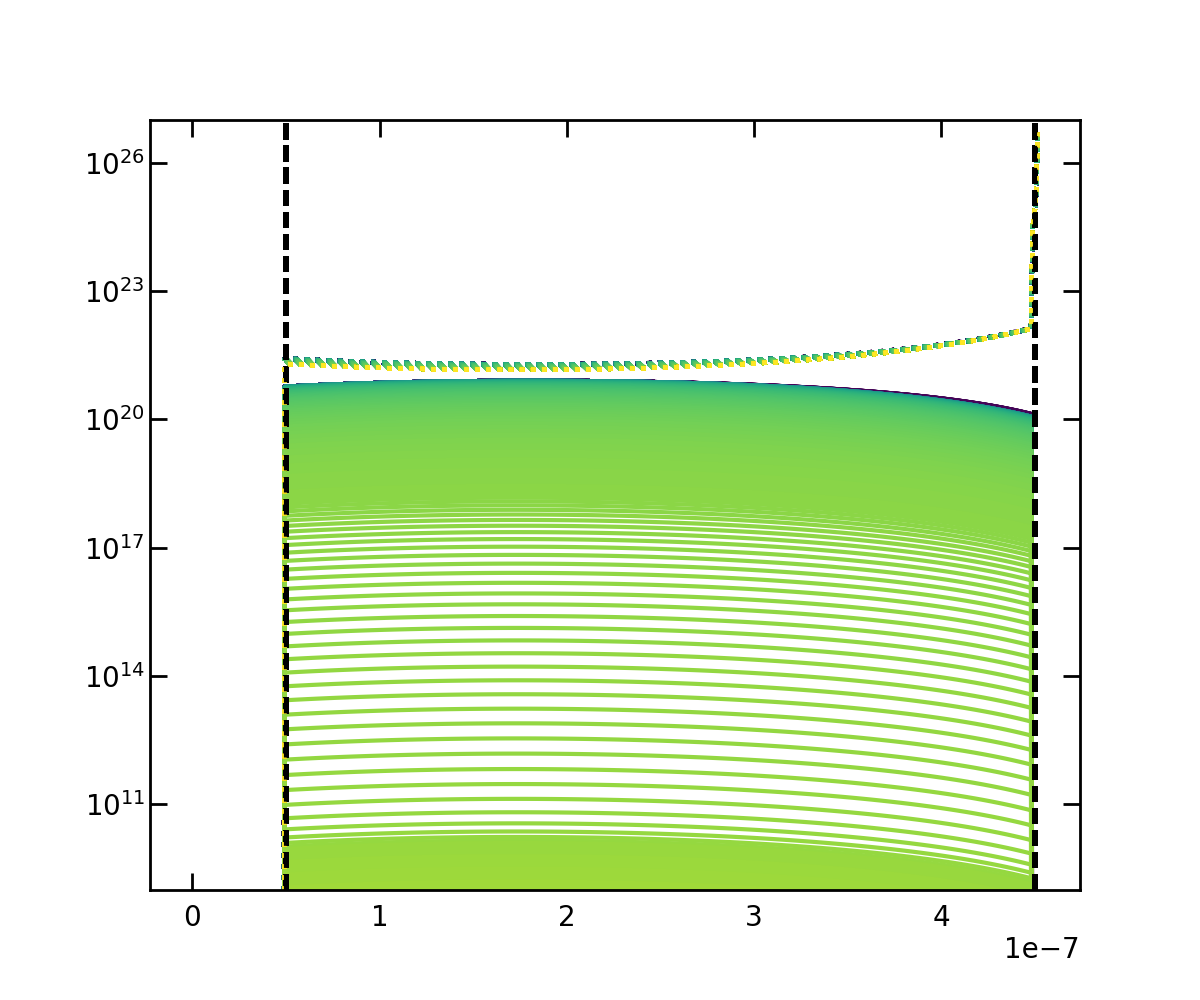

In [9]:
# plt.figure()
colors = cm.viridis((np.linspace(0,1,max(len(times),4)+1)) ) # Color range for plotting
for G0 in G0s:
    idx = 0
    for Gen in Gens:
        var_dat = pd.read_csv(os.path.join(path2simu,'Var_TrPL_G_{:.1e}_G0_{:.2e}.dat'.format(Gen,G0)),delim_whitespace=True)

        # group by time
        times = var_dat['time'].unique()
        plt.figure()
        idx = 0
        for t in times:
            df = var_dat[var_dat['time']==t]
            plt.semilogy(df['x'],df['n'],color=colors[idx])#,label='n')
            plt.semilogy(df['x'],df['p'],':',color=colors[idx])#,label='p')
            # put a vertical line at x = L_LTL and x = L - L_RTL
            plt.axvline(x=L_LTL, color='k', linestyle='--')
            plt.axvline(x=L - L_RTL, color='k', linestyle='--')
            idx += 1
        plt.ylim(1e9,1e27)
        # plt.legend()
plt.show()

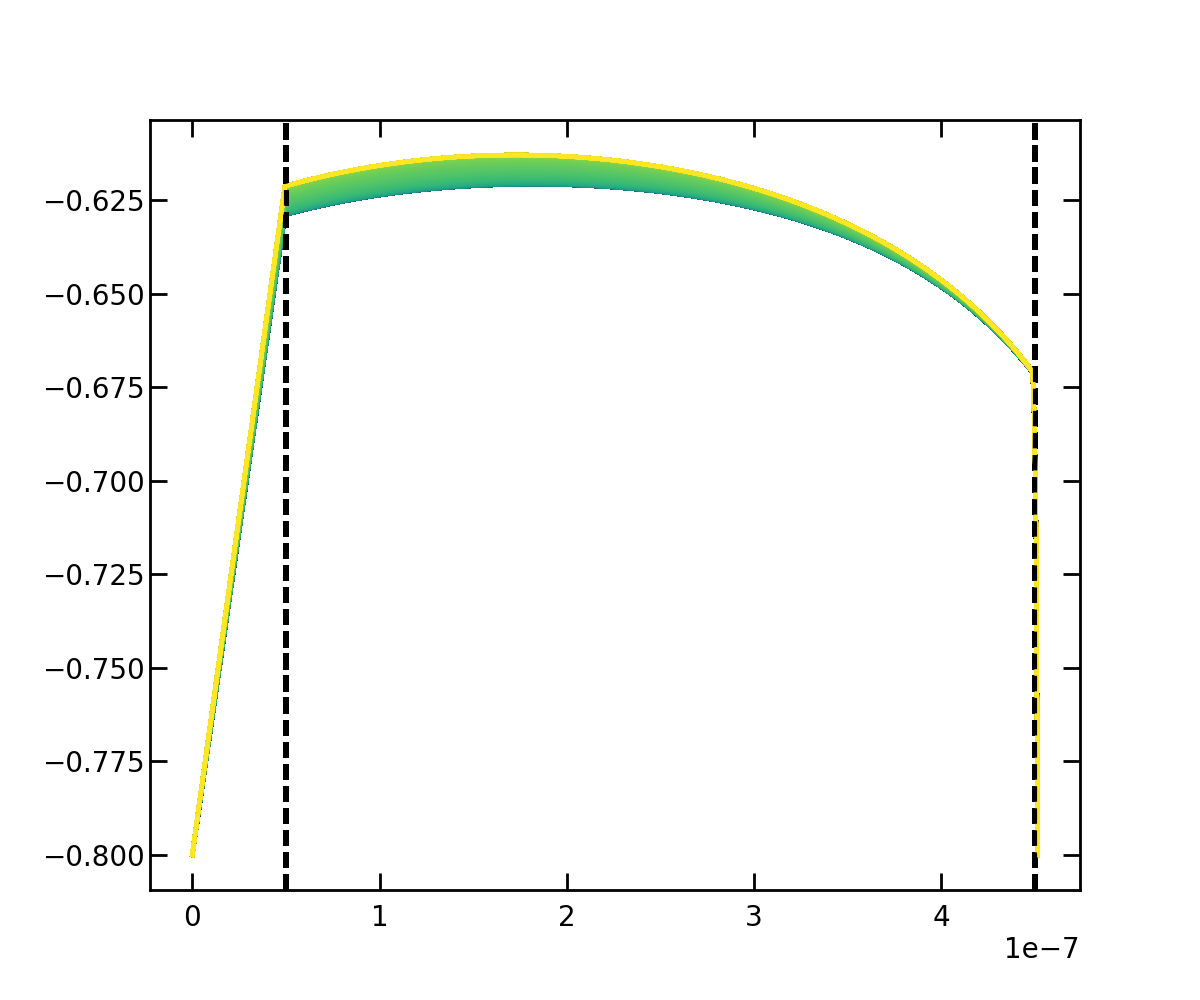

In [10]:
# plt.figure()
colors = cm.viridis((np.linspace(0,1,max(len(times),4)+1)) ) # Color range for plotting
for G0 in G0s:
    idx = 0
    for Gen in Gens:
        var_dat = pd.read_csv(os.path.join(path2simu,'Var_TrPL_G_{:.1e}_G0_{:.2e}.dat'.format(Gen,G0)),delim_whitespace=True)

        # group by time
        times = var_dat['time'].unique()
        plt.figure()
        idx = 0
        for t in times:
            df = var_dat[var_dat['time']==t]
            plt.plot(df['x'],df['V'],color=colors[idx])#,label='n')
            
            # put a vertical line at x = L_LTL and x = L - L_RTL
            plt.axvline(x=L_LTL, color='k', linestyle='--')
            plt.axvline(x=L - L_RTL, color='k', linestyle='--')
            idx += 1
        # plt.ylim(1e9,1e27)
        # plt.legend()
plt.show()

0.0


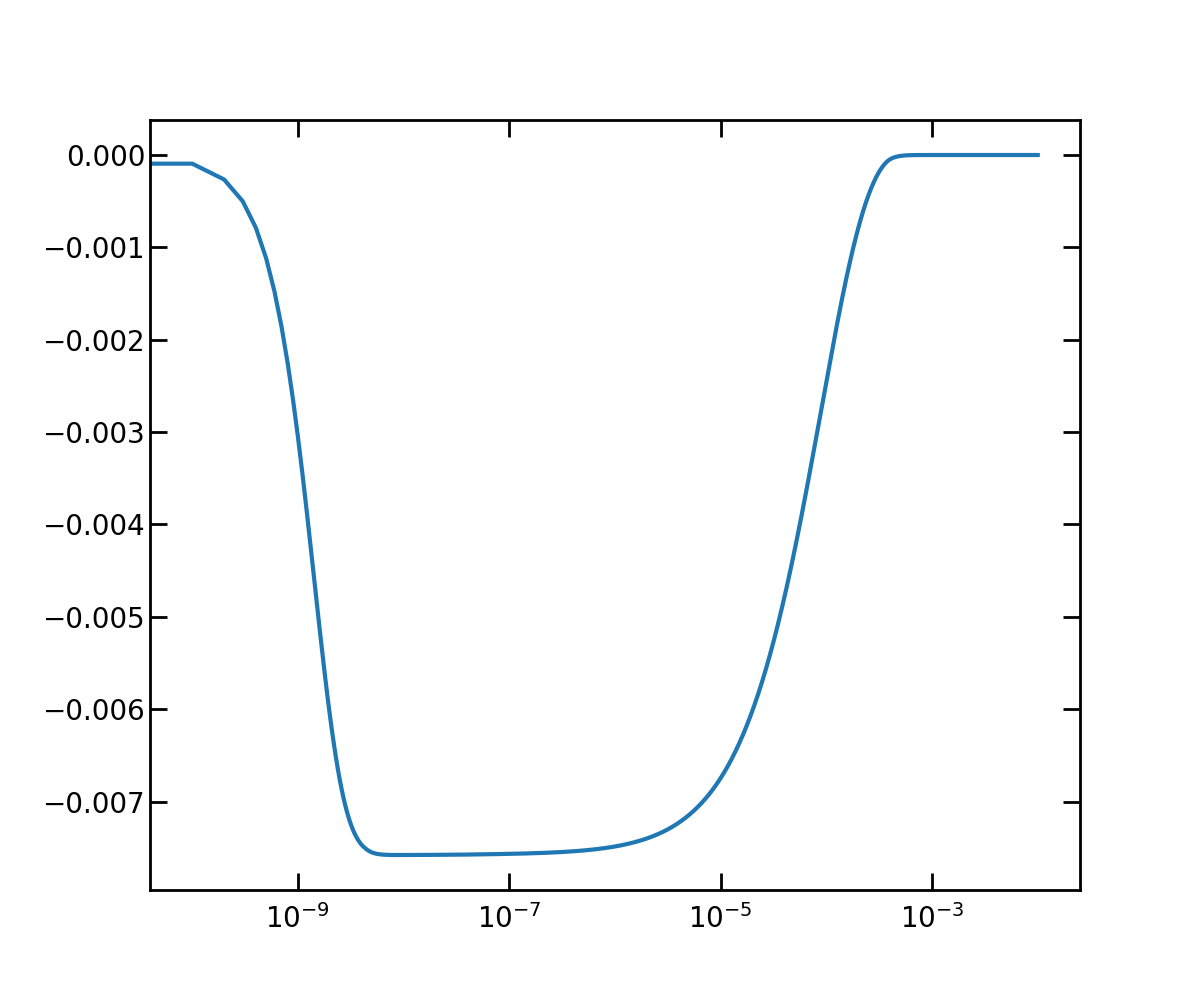

In [13]:
plt.figure()
for G0 in G0s:
    idx = 0
    for Gen in Gens:
        # try:
        var_dat = pd.read_csv(os.path.join(path2simu,'Var_TrPL_G_{:.1e}_G0_{:.2e}.dat'.format(Gen,G0)),delim_whitespace=True, on_bad_lines = 'warn')

        # filter x < 5e-9
        # L = max(var_dat['x'])
        # var_dat = var_dat[var_dat['mun'] == 5e-4] # make sure we are in the perovskite layer
        var_dat = var_dat[var_dat['x'] > L_LTL]
        # var_dat = var_dat[var_dat['mun'] > 1e-7]

        grouped = var_dat.groupby('time')
        
        SPV = []
        for group in grouped:

            SPV.append(group[1]['V'].iloc[0] - group[1]['V'].iloc[-1])

        # SPV = ((q*Lac**2/2)*(ps-ns-nt-St)/(eps_0*eps_r))
        SPV = np.asarray(SPV)
        SPV = SPV - SPV[0]


        plt.semilogx(times,SPV )
        # except:
        #     pass
print(SPV[0])
plt.show()

In [12]:
# Clean output files from simulation folders
Do_Cleaning = False # Careful, this will delete all files in the folder
if Do_Cleaning:
    clean_up_output('tj',path2simu)
    clean_up_output('tVG',path2simu)
    clean_up_output('JV',path2simu)
    clean_up_output('Var',path2simu)
    clean_up_output('scPars',path2simu)
    clean_up_output('log',path2simu)
    clean_up_output('Str4Parallel',path2simu)
    clean_up_output('joblog',path2simu)
    clean_file_type('.jpg',path2simu) # clean all jpg files
    clean_file_type('.png',path2simu) # clean all png files
else:
    clean_up_output('log',path2simu)
    clean_up_output('Str4Parallel',path2simu)
    clean_up_output('joblog',path2simu)
    